Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
num_class = 12
train: 40  test: 13


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0750 - loss: 2.4824 - val_accuracy: 0.5385 - val_loss: 2.0739


---- Fine-tune Iteration 1/3 ----


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 2.1098 - val_accuracy: 0.5385 - val_loss: 1.9533


---- Fine-tune Iteration 2/3 ----


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 2.0443 - val_accuracy: 0.5385 - val_loss: 1.8652


---- Fine-tune Iteration 3/3 ----


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 2.0872 - val_accuracy: 0.5385 - val_loss: 1.9017


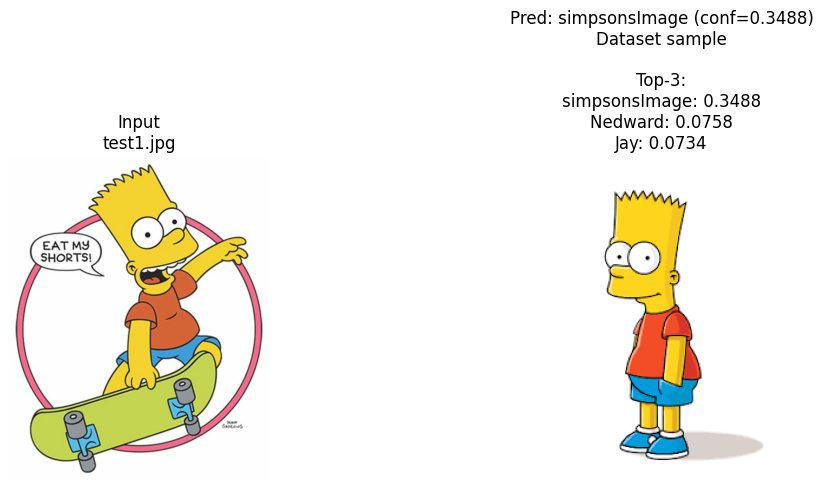

圖片: test1.jpg
預測角色: simpsonsImage
信心度: 0.3488
Top-3:
  - simpsonsImage: 0.3488
  - Nedward: 0.0758
  - Jay: 0.0734
對照圖: /content/drive/MyDrive/imageAI/simpsons_dataset/simpsonsImage/images1.jpg


('simpsonsImage',
 0.3487577736377716,
 '/content/drive/MyDrive/imageAI/simpsons_dataset/simpsonsImage/images1.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, json, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

def read_img(location, test_ratio=0.2, x_s=200, y_s=200):
    x_data, y_data = [], []
    label_name = []
    label = 0

    dirs = sorted([d for d in os.listdir(location) if os.path.isdir(os.path.join(location, d))])

    for folder in dirs:
        imgs = []
        for pic in glob.glob(os.path.join(location, folder, '**', '*.*'), recursive=True):
            if pic.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    im = Image.open(pic).convert('RGB')
                    im = im.resize((x_s, y_s), Image.LANCZOS)
                    im = np.array(im)
                    if im.shape == (y_s, x_s, 3):
                        imgs.append(im)
                except Exception as e:
                    print(f"Error reading {pic}: {e}")
                    continue

        if len(imgs) == 0:
            continue

        label_name.append(folder)
        x_data.extend(imgs)
        y_data.extend([label] * len(imgs))
        label += 1

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    if len(x_data) == 0:
        raise ValueError("No images found. Please check dataset path.")
    if len(x_data) < len(set(y_data)) * 2:
        return x_data, y_data, np.array([]), np.array([]), label_name

    effective_test_ratio = max(test_ratio, len(set(y_data)) / len(x_data) + 0.01)
    if effective_test_ratio >= 1.0:
        effective_test_ratio = 0.2

    try:
        x_train, x_test, y_train, y_test = train_test_split(
            x_data, y_data, test_size=effective_test_ratio, stratify=y_data, random_state=42
        )
    except ValueError:
        x_train, x_test, y_train, y_test = train_test_split(
            x_data, y_data, test_size=effective_test_ratio, random_state=42
        )

    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), label_name

dataset_path = '/content/drive/MyDrive/imageAI/simpsons_dataset'

img_rows = 200
img_cols = 200

x_train, y_train, x_test, y_test, label_name = read_img(dataset_path, test_ratio=0.2, x_s=img_cols, y_s=img_rows)
num_class = len(label_name)
print("num_class =", num_class)
print("train:", len(x_train), " test:", len(x_test))

x_train = x_train.reshape(-1, img_rows, img_cols, 3).astype('float32') / 255.0
if len(x_test) > 0:
    x_test = x_test.reshape(-1, img_rows, img_cols, 3).astype('float32') / 255.0

y_train_cat = to_categorical(y_train, num_classes=num_class)
y_test_cat = to_categorical(y_test, num_classes=num_class) if len(y_test) > 0 else np.array([])

input_shape = (img_rows, img_cols, 3)

model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_class, activation='softmax')
])

optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

EPOCHS_FIRST = 1
if len(x_test) > 0:
    model.fit(x_train, y_train_cat, batch_size=64, epochs=EPOCHS_FIRST, verbose=1, validation_data=(x_test, y_test_cat))
else:
    model.fit(x_train, y_train_cat, batch_size=64, epochs=EPOCHS_FIRST, verbose=1)

MODEL_PATH = 'Simpson.h5'
LABEL_PATH = 'labels.json'

model.save(MODEL_PATH)
with open(LABEL_PATH, 'w', encoding='utf-8') as f:
    json.dump(label_name, f, ensure_ascii=False, indent=2)

FINE_TUNE_ITERS = 3
for i in range(FINE_TUNE_ITERS):
    print(f'---- Fine-tune Iteration {i+1}/{FINE_TUNE_ITERS} ----')
    model = load_model(MODEL_PATH)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    if len(x_test) > 0:
        model.fit(x_train, y_train_cat, batch_size=64, epochs=1, verbose=1, validation_data=(x_test, y_test_cat))
    else:
        model.fit(x_train, y_train_cat, batch_size=64, epochs=1, verbose=1)

    model.save(MODEL_PATH)
    K.clear_session()

def find_one_image_in_class(dataset_root: str, class_name: str):
    class_dir = os.path.join(dataset_root, class_name)
    if not os.path.isdir(class_dir):
        return None

    patterns = [
        os.path.join(class_dir, "**", "*.jpg"),
        os.path.join(class_dir, "**", "*.jpeg"),
        os.path.join(class_dir, "**", "*.png"),
    ]
    candidates = []
    for p in patterns:
        candidates.extend(glob.glob(p, recursive=True))

    return candidates[0] if candidates else None


def predict_and_show_colab(img_path, dataset_root, model_path=MODEL_PATH, label_path=LABEL_PATH, img_size=(200, 200)):
    model = load_model(model_path)
    with open(label_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)

    input_img_pil = Image.open(img_path).convert('RGB')
    x = np.array(input_img_pil.resize(img_size)).astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)

    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    conf = float(np.max(probs))
    pred_label = labels[idx]

    ref_path = find_one_image_in_class(dataset_root, pred_label)
    ref_img_pil = Image.open(ref_path).convert('RGB') if ref_path else None
    top3 = np.argsort(probs)[::-1][:3]
    top3_text = "\n".join([f"{labels[i]}: {probs[i]:.4f}" for i in top3])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(input_img_pil)
    plt.axis('off')
    plt.title(f"Input\n{os.path.basename(img_path)}")

    plt.subplot(1, 2, 2)
    if ref_img_pil is not None:
        plt.imshow(ref_img_pil)
        plt.axis('off')
        plt.title(f"Pred: {pred_label} (conf={conf:.4f})\nDataset sample\n\nTop-3:\n{top3_text}")
    else:
        plt.axis('off')
        plt.title(f"Pred: {pred_label} (conf={conf:.4f})\nNo dataset sample found\n\nTop-3:\n{top3_text}")

    plt.tight_layout()
    plt.show()

    print(f"圖片: {os.path.basename(img_path)}")
    print(f"預測角色: {pred_label}")
    print(f"信心度: {conf:.4f}")
    print("Top-3:")
    for i in top3:
        print(f"  - {labels[i]}: {probs[i]:.4f}")
    print("對照圖:", ref_path if ref_path else "找不到")

    return pred_label, conf, ref_path

test_img = '/content/drive/MyDrive/imageAI/simpsons_dataset/test1.jpg'
predict_and_show_colab(test_img, dataset_path)